In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter
from AnchorOptimalProjector import *

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [3]:
def load_model_data(model, var, path='../data/'):
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    tas_array = ds[var].values
    # Close the dataset
    ds.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='tas', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='tas', n_sample=10, path='../data/', coarse=12, window_size=10):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path)
        shape = tas_array.shape
        
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        tas_regional = tas_array.reshape(shape[0], shape[1], shape[2]//coarse, coarse, shape[3]//coarse, coarse)
        X_temp = tas_regional.mean(axis=(3, 5))
        rmt = X_temp.mean(axis=0)
        # Calculate regional internal variability
        riv = rmt - X_temp
        # Create a 1D convolution kernel for the moving average
        kernel = np.ones(window_size) / window_size
        # Smooth the regional internal variability using a moving average
        A_temp = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=riv)
            
            
        X_temp = X_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)).reshape(shape[0]*shape[1], shape[2]*shape[3])
        A_temp = A_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
            A = A_temp[idxs, :] 
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
            A = np.vstack((A, A_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
        del A_temp
    return A, X, y

In [4]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [5]:
B = 50
models_test = random.choices(models, k=B)
models_train = [[model for model in models if model != model_test ] for model_test in models_test ]

In [6]:
occurence_models_test = Counter(models_test)

In [7]:
occurence_models_test

Counter({'MIROC6': 11,
         'CanESM5': 6,
         'MIROC-ES2L': 11,
         'CESM2': 13,
         'MPI-ESM1-2-LR': 9})

In [8]:
N = 2500
n_alpha = 5
alphas = np.logspace(1, 3, n_alpha)
coarse = 6
n_cv = 3
gammas = [1, 2, 5]

In [9]:
try :
    directory = '../weights/'
    file = 'Anchor_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
    with open(directory + file, 'rb') as f:
        weights = pickle.load(f)
except:
    print('Weights does not exists!')
    weights = {model:{gamma : {'weights':None, 'n_samples': N*occurence_models_test[model]} for gamma in gammas} for model in models}
    
for model in models : 
    for gamma in gammas :
        if gamma not in weights[model].keys():
            weights[model][gamma]['weights'] = None
            weights[model][gamma]['n_samples'] = N*occurence_models_test[model]

Weights does not exists!


In [10]:
weights

{'CanESM5': {1: {'weights': None, 'n_samples': 15000},
  2: {'weights': None, 'n_samples': 15000},
  5: {'weights': None, 'n_samples': 15000}},
 'MIROC-ES2L': {1: {'weights': None, 'n_samples': 27500},
  2: {'weights': None, 'n_samples': 27500},
  5: {'weights': None, 'n_samples': 27500}},
 'MPI-ESM1-2-LR': {1: {'weights': None, 'n_samples': 22500},
  2: {'weights': None, 'n_samples': 22500},
  5: {'weights': None, 'n_samples': 22500}},
 'MIROC6': {1: {'weights': None, 'n_samples': 27500},
  2: {'weights': None, 'n_samples': 27500},
  5: {'weights': None, 'n_samples': 27500}},
 'CESM2': {1: {'weights': None, 'n_samples': 32500},
  2: {'weights': None, 'n_samples': 32500},
  5: {'weights': None, 'n_samples': 32500}}}

In [11]:

for i in tqdm(range(len(models_test))):
    m_train, m_test = models_train[i], models_test[i]
    #print('Fitting optimal ridge {}/{}'.format(i, B))
    print("Extracting data...", end='\r')
    A_train, X_train, Y_train = load_data_models(m_train, n_sample=N, coarse=coarse)
    A_test, X_test, Y_test = load_data_models([m_test], n_sample=N, coarse=coarse)
    print("Data extracted!")
    
    print('Transform training data with AOP...', end='\r')
    AOP = AnchorOptimalProjection(gamma=gammas)
    X_trains, Y_trains = AOP.fit_transform(A_train, X_train, Y_train)
    print('Data transformed!')
    
    for gamma in gammas:
        print(r"Training anchor ($\gamma$={:.1f})...".format(gamma), end='\r')
        ridge = RidgeCV(alphas=alphas, cv=n_cv) #cv=zip(idx_val, idx_val))
        ridge.fit(X_trains[gamma], Y_trains[gamma])
        print('Selected alpha : {}'.format(ridge.alpha_))
        print("Ridge regression fitted!")
        print('Saving weights...', end='\r')
        if weights[m_test][gamma]['weights'] is None:
            weights[m_test][gamma]['weights'] = np.hstack((ridge.coef_, ridge.intercept_[:,None]))
        else:
            weights[m_test][gamma]['weights'] = (weights[m_test][gamma]['n_samples']*weights[m_test][gamma]['weights'] + N*occurence_models_test[m_test]*np.hstack((ridge.coef_, ridge.intercept_[:,None])))/(N*occurence_models_test[m_test] + weights[m_test][gamma]['n_samples'])
            weights[m_test][gamma]['n_samples'] += N*occurence_models_test[m_test]
        print("Weights saved!")
# Save the weights for this alpha to a file
file_path = f'../weights/Anchor_weights_stability_n{N}_coarse{coarse}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(weights, f)

  0%|          | 0/50 [00:00<?, ?it/s]

Data extracted!
Data transformed!g data with AOP...


  0%|          | 0/50 [04:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
directory = '../weights/'
file = 'Anchor_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
with open(directory + file, 'rb') as f:
    weights = pickle.load(f)

In [ ]:
R = 10
scores_pattern = {model:{gamma:[] for gamma in weights[model].keys()} for model in models}
for b in tqdm(range(R)):
    for model in models:
        for gamma in weights[model].keys():
            print("Extracting data...", end='\r')
            A_test, X_test, Y_test = load_data_models([model], var='tas', coarse=coarse, n_sample=N)
            print('Data extracted!')
            print("Predicting data ...", end='\r')
            A, B = weights[model][gamma]['weights'][:,:-1], weights[model][gamma]['weights'][:,-1]
            Y_pred = X_test @ A.T + B 
            print("Data predicted")
            print("Computing scores for ({} - {})".format(model, gamma), end='\r')
            score_pattern = r2_score(Y_test, Y_pred, multioutput='raw_values')
            scores_pattern[model][gamma].append(score_pattern)
            print("Score computed!")


  0%|          | 0/10 [00:00<?, ?it/s]

Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)
Data extracted!.

 10%|█         | 1/10 [02:31<22:47, 151.95s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


 20%|██        | 2/10 [04:37<18:13, 136.68s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


 30%|███       | 3/10 [06:38<15:03, 129.10s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


 40%|████      | 4/10 [08:33<12:22, 123.77s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


 50%|█████     | 5/10 [10:36<10:17, 123.55s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


 60%|██████    | 6/10 [12:34<08:06, 121.55s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


 70%|███████   | 7/10 [14:38<06:07, 122.48s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


 80%|████████  | 8/10 [16:40<04:04, 122.14s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


 90%|█████████ | 9/10 [18:38<02:00, 120.80s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


100%|██████████| 10/10 [20:39<00:00, 123.91s/it]

Score computed!


In [ ]:
gamma=5

In [ ]:
np.array([np.mean(scores_pattern[model][gamma], axis=1) for model in models]).mean()

0.5442445862999086

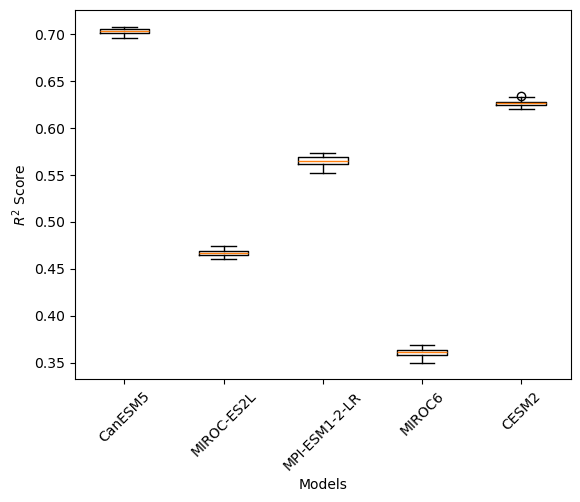

In [ ]:
plt.boxplot([np.mean(scores_pattern[model][gamma], axis=1) for model in models])
# Boxplot
# Set xticklabels with alpha values
plt.xticks(range(1, len(models) + 1), [model for model in models], rotation=45)

# Set xlabel with alphas
plt.xlabel(r'Models')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

directory = '../Results'
plt.savefig(directory + "/R2_anchor{}_stability_coarse{}.pdf".format(gamma, coarse), format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
model = 'MPI-ESM1-2-LR'
scores_pattern_maps = np.mean(scores_pattern[model][gamma], axis=0).reshape(len(lat), len(lon))

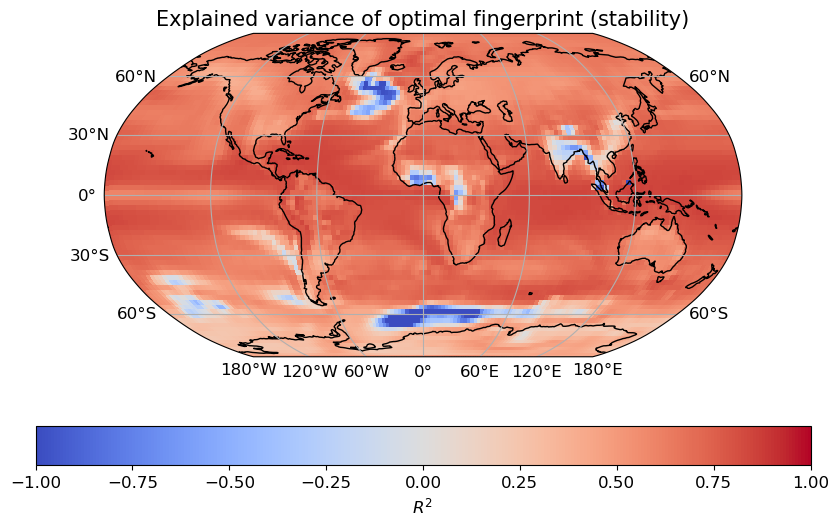

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, diff_r2_map, diff_corr_map, max_val_r2, max_val_corr

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot for diff_r2_map
norm_r2 = TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1)
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

ax.set_title(r'Explained variance of optimal fingerprint (stability)', fontsize=15)

cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$ ', fontsize=12) 

directory = '../Results'
plt.savefig(directory + "/maps_R2_anchor{}_stability_coarse_{}_{}.pdf".format(gamma, coarse, model), format="pdf", bbox_inches="tight")


plt.show()